In [705]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time

# generate data

In [706]:
# In real-world scenarios, learning how the data was generated is impractical. Do not rely on this function while doing research.

# Returns: x [num, dim], label [num, 1], mislabel_rate
def generate_data(dim, num):
    x = np.random.normal(0, 10, [num, dim])
    coef = np.random.uniform(-1, 1, [dim, 1])
    pred = np.dot(x, coef)
    pred_n = (pred - np.mean(pred)) / np.sqrt(np.var(pred))
    label = np.sign(pred_n)
    mislabel_value = np.random.uniform(0, 1, num)
    mislabel = 0
    for i in range(num):
        if np.abs(pred_n[i]) < 1 and mislabel_value[i] > 0.9 + 0.1 * np.abs(pred_n[i]):
            label[i] *= -1
            mislabel += 1
    return x, label, mislabel/num

In [707]:
# example
x, y, mr = generate_data(5, 100)
print(x.shape)

(100, 5)


In [708]:
x[:5], y[:5]

(array([[-12.54583028,  -8.20431848,   1.01211124, -16.01806475,
          -0.09566493],
        [  3.95540878,  -5.27792693,  -3.34068579,   3.34020289,
          12.7241518 ],
        [  0.10345802,  -9.07671133,   3.30644338, -13.98964425,
           3.83242899],
        [  7.96460834,  15.56780411,   0.18434555,  -6.44006022,
           0.38703461],
        [ -3.08543697,  -3.58246841,   9.68010561,  13.43042519,
          20.94003166]]),
 array([[-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.]]))

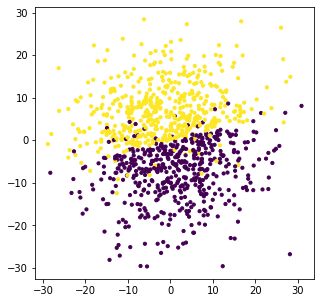

In [709]:

plt.figure(figsize=(5, 5))
test_x,test_y,test_mr = generate_data(2,1000)

plt.scatter(test_x[:,0],test_x[:,1],c=test_y[:,0],s=10)
plt.show()

In [710]:
a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
b = np.array([1, 2, 3, 4])
c = np.zeros(4)
c

array([0., 0., 0., 0.])

# write your model class

In [711]:
class SVM:
    def __init__(self, dim, soft=0.1, method=None):
        """


        Adding other parameters is acceptable but not necessary.
        """


        self.w = np.zeros(dim)

        self.b = 0.0

        self.soft = soft

        self.method = method

    def fit(self, X, y):
        """


        Fit the coefficients via your method1


        """

    def loss(self, X, y):
        """
        Calculate the loss.
        """

    def calVal(self, x):
        return np.dot(x, self.w) + self.b

    def z(self, x, y):
        return self.calVal(x) * y

    def predict(self, X):
        """


        Generate prediction probabilities on a new


        collection of data points by your model.


        """
        val = self.calVal(X)
        y_pred = np.zeros(len(val))
        y_pred[np.where(val > 0)] = 1
        y_pred[np.where(val <= 0)] = -1
        return y_pred

In [712]:
# Using traditional method: sotchastic gradient descent to update loss function
# Then we can get the optimal solution of w and b

# Loss function:
# 1. Hinge loss
# 2. Exp loss
# 3. Logistic loss


from cv2 import exp


class SVM1(SVM):
    def loss(self, X, y):
        """
        Calculate the loss.
        """

        loss = np.dot(self.w, self.w) / 2.0
        if self.method not in ["hinge", "exp", "log"]:
            return loss

        z = self.z(X, y)
        if self.method == "hinge":
            z = 1 - z
            z[z < 0] = 0
            loss += self.soft * np.sum(z)
        elif self.method == "exp":
            loss += self.soft * np.sum(np.exp(-z))
        elif self.method == "log":
            loss += self.soft * np.sum(np.log(1 + np.exp(-z)))
        return loss

    def grad_loss(self, X, y):
        gradw = self.w.copy()
        gradb = 0
        if self.method not in ["hinge", "exp", "log"]:
            return gradw, gradb
        z = self.z(X, y)
        if self.method == "hinge":
            idx = z < 1
            gradw -= np.sum(self.soft * y[idx][:, np.newaxis] * X[idx], axis=0)
            # gradw = gradw-np.sum(self.soft * y[idx][:, np.newaxis] * X[idx], axis=0)
            gradb -= np.sum(self.soft * y[idx])
        elif self.method == "exp":
            exp_values = np.exp(-z)
            gradw -= self.soft * np.sum(
                exp_values[:, np.newaxis] * y[:, np.newaxis] * X, axis=0
            )
            gradb -= self.soft * np.sum(exp_values * y)
        elif self.method == "log":
            exp_values = np.exp(-z)
            gradw -= self.soft * np.sum(
                exp_values[:, np.newaxis] * y[:, np.newaxis] * X, axis=0
            )
            gradb -= self.soft * np.sum(exp_values * y)

        return gradw, gradb

    def fit(self, X, y, maxIter=2e3, lr=1e-5):
        """
        Fit the coefficients via your method1
        """

        loss = []
        for _ in range(int(maxIter)):
            gradw, gradb = self.grad_loss(X, y)
            loss.append(self.loss(X, y))
            self.w -= lr * gradw
            self.b -= lr * gradb
            if loss[-1] < 1:
                break
        return loss

In [713]:
from itertools import count
from turtle import update


class SVM2(SVM):
    def __init__(self, dim, soft=1, method="SOM"):
        """
        Adding other parameters is acceptable but not necessary.
        """
        self.w = np.zeros(dim)
        self.b = 0.0
        self.dim = dim

        self.m = 1
        self.alphas = None
        self.C = soft
        self.toler = 0.0
        self.label = None
        self.X = None
        self.y = None

    def loss(self, X, y):
        """
        Calculate the loss.
        """

        loss = np.dot(self.w, self.w) / 2.0
        idx = np.where((self.alphas > 0))[0]
        loss += self.C*np.sum((1 - self.z( self.X[idx], self.y[idx])))
        return loss

    def selectJRand(self, i):
        j = i
        while j == i:
            j = np.random.randint(0, self.m, 1)[0]
        return j

    def calE(self, x, y):
        return self.calVal(x) - y

    def calK(self, i, j):
        return np.dot(self.X[i], self.X[j])

    def updateW(self):
        self.w = np.sum(
            self.alphas[:, np.newaxis] * self.y[:, np.newaxis] * self.X, axis=0
        )

    def updateB(self):
        idx = np.where((self.alphas > 0))[0]
        if len(idx) > 0:
            self.b = np.mean(self.y[idx] - np.dot(self.X[idx], self.w))
        else:
            self.b = 0

    def updateE(self):
        self.E = self.calE(self.X, self.y)

    def selectJIndex(self, i, Ei):
        # 启发式选择第二个变量
        # 选择使得|Ei-Ej|最大的j
        
        #random select
        j = self.selectJRand(i)
        Ej = self.calE(self.X[j], self.y[j])
        # 选择使得|Ei-Ej|最大的j
        deltaE_values = np.abs(Ei - self.E)

        # 找到最大的deltaE对应的索引
        max_k = np.argmax(deltaE_values)
        Ek = self.E[max_k]
        if max_k == i or deltaE_values[max_k] == 0:
            return j, Ej
        return max_k, Ek

    def innerLoop(self, i):
        Ei = self.calE(self.X[i], self.y[i])
        # 选择违反KKT条件的点即：
        # 如果alpha<c，那么y*f(x)<1
        # 如果alpha>0，那么y*f(x)>1
        if ((self.y[i] * Ei < -self.toler) and (self.alphas[i] < self.C)) or (
            (self.y[i] * Ei > self.toler) and (self.alphas[i] > 0)
        ):
            j, Ej = self.selectJIndex(i, Ei)

            eta = self.calK(i, i) + self.calK(j, j) - 2 * self.calK(i, j)
            if eta <= 0:
                return 0

            alphaold_i = self.alphas[i].copy()
            alphaold_j = self.alphas[j].copy()
            L = 0
            H = 0
            if self.label[i] != self.label[j]:
                L = max(0, alphaold_j - alphaold_i)
                H = min(self.C, self.C + alphaold_j - alphaold_i)
            else:
                L = max(0, alphaold_j + alphaold_i - self.C)
                H = min(self.C, alphaold_j + alphaold_i)

            alphanew_j = alphaold_j + self.y[j] * (Ei - Ej) / eta
            alphanew_j = min(max(alphanew_j, L), H)
            self.alphas[j] = alphanew_j
            delta_alpha_j = self.alphas[j] - alphaold_j
            if abs(delta_alpha_j) < self.C * 1e-5:
                return 0

            self.alphas[i] = alphaold_i - self.label[i] * self.label[j] * delta_alpha_j
            delta_alpha_i = self.alphas[i] - alphaold_i

            b1 = (
                -Ei
                + self.b
                - self.label[i] * self.calK(i, i) * delta_alpha_i
                - self.label[j] * self.calK(j, i) * delta_alpha_j
            )
            b2 = (
                -Ej
                + self.b
                - self.label[i] * self.calK(i, j) * delta_alpha_i
                - self.label[j] * self.calK(j, j) * delta_alpha_j
            )
            if (0 < self.alphas[i]) and (self.alphas[i] < self.C):
                self.b = b1
            elif (0 < self.alphas[j]) and (self.alphas[j] < self.C):
                self.b = b2
            else:
                self.b = (b1 + b2) / 2.0
            self.updateW()  # E is denpend on w, w is denpend on alpha
            # self.updateB()
            self.updateE()
            return 1
        else:
            return 0

    def fit(self, X, y, maxIter=1e3, lr=1e-5):
        """
        Fit the coefficients via SOM

        """
        self.m = y.size
        self.alphas = np.zeros(self.m)
        self.toler = 1e-4
        self.y = y
        self.label = y
        self.X = X
        self.E = np.zeros(self.m)
        iter = 0
        entrySet = True
        alphaPairsChanged = 0
        loss = []

        #init
        self.updateW()
        self.updateB()
        self.updateE()


        while (iter < maxIter) and ((alphaPairsChanged > 0) or (entrySet)):
            alphaPairsChanged = 0
            if entrySet:
                # 遍历所有样本
                for i in range(self.m):
                    alphaPairsChanged += self.innerLoop(i)
                    # if i % 100 == 0:
                    loss.append(self.loss(X, y))
                    #     print(
                    #         "full set loop, iter: %d, alphapairschanged: %d, iterNum: %d"
                    #         % (i, alphaPairsChanged, iter)
                    #     )
                iter += 1
            else:
                # 遍历所有非边界点
                nonBoundIs = np.nonzero((self.alphas > 0) * (self.alphas < self.C))[0]
                for i in nonBoundIs:
                    alphaPairsChanged += self.innerLoop(i)
                    loss.append(self.loss(X, y))
                    # if i % 100 == 0:
                    #     print(
                    #         "Non-bound set loop, iter: %d, alphapairschanged: %d, iterNum: %d"
                    #         % (i, alphaPairsChanged, iter)
                    #     )
                iter += 1
            if entrySet:
                entrySet = False
            elif alphaPairsChanged == 0:
                entrySet = True
                # print("iter num: %d" % (iter))
        
        print("Spprt vector num: %d" % (np.sum(self.alphas > 0 & (self.alphas < self.C))))

        return loss

# construct and train your models

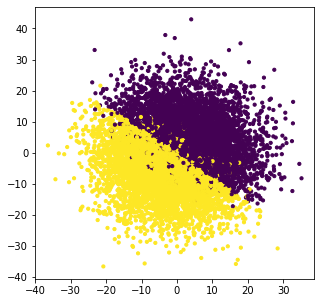

model 1 time: 1.1747328999999809
Spprt vector num: 2
model 2 time: 0.5571046999993996


In [714]:
# generate data
dim, num = 2, 10000

X_data, y_data, mislabel = generate_data(dim, num)
y_data = y_data.ravel()
# split data

idx = np.random.permutation(num)
X_data = X_data[idx, :]
y_data = y_data[idx]


plt.figure(figsize=(5, 5))
plt.scatter(X_data[:, 0], X_data[:, 1], c=y_data, s=10)
plt.show()

t = (int)(6 * num / 10)
X_train = X_data[0:t, :]
X_test = X_data[t:num, :]
y_train = y_data[0:t]
y_test = y_data[t:num]


# construct model and train (remember to record your time consumption)


# model1 = SVM1()
m1 = SVM1(dim, soft=0.1, method="hinge")
t1 = time.perf_counter()

# model1.fit()
loss1 = m1.fit(X_train, y_train)
t2 = time.perf_counter()
print("model 1 time: " + str(t2 - t1))

# model2 = SVM2()
m2 = SVM2(dim, soft=1, method="SOM")
t1 = time.perf_counter()
# model2.fit()
loss2 = m2.fit(X_train, y_train, maxIter=400)
t2 = time.perf_counter()
print("model 2 time: " + str(t2 - t1))


# predict and compare your results

In [715]:
# make prediction
# pred = model1.predict()
pred1 = m1.predict(X_test)
pred2 = m2.predict(X_test)
# compare with generated label
acc1 = np.sum(pred1 == y_test) / len(y_test)
acc2 = np.sum(pred2 == y_test) / len(y_test)
# compare each method(in terms of accuracy, time consumption, etc.)

# (Optional) compare with sklearn
print("model 1 accuracy: " + str(acc1))
print("model 2 accuracy: " + str(acc2))


model 1 accuracy: 0.9605
model 2 accuracy: 0.90425


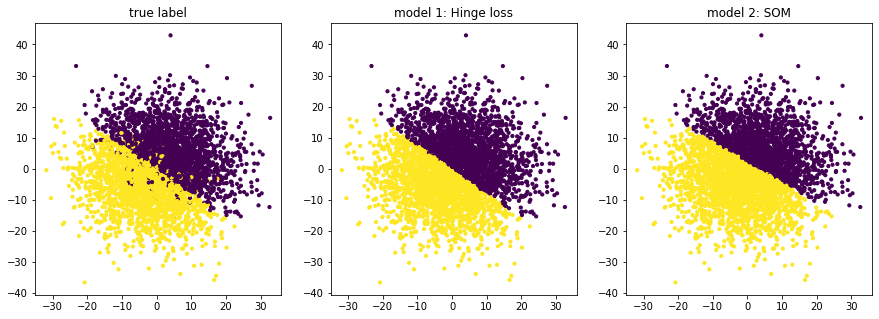

In [719]:
# show the miss classification plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=10)
plt.title("true label")

plt.subplot(1, 3, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=pred1, s=10)
plt.title("model 1: Hinge loss")

plt.subplot(1, 3, 3)
plt.scatter(X_test[:, 0], X_test[:, 1], c=pred2, s=10)
plt.title("model 2: SOM")
plt.show()


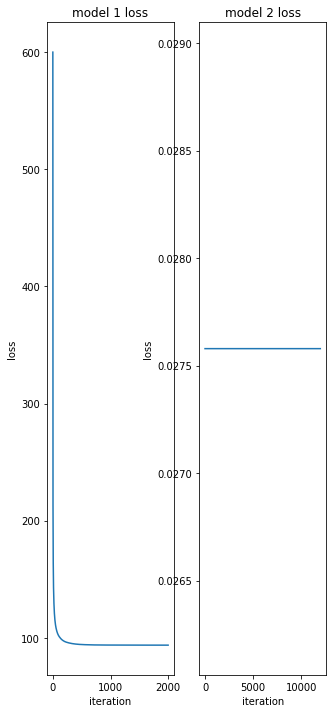

In [722]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(loss1)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("model 1 loss")
plt.subplot(122)
plt.plot(loss2)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("model 2 loss")
plt.show()